<a href="https://colab.research.google.com/github/plaban1981/INEURON/blob/Supervised-Models/XGBOOST_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:
In this assignment students need to predict whether a person makes over
50K per year or not from classic adult dataset using XGBoost.

# Data Set Information:
Extraction was done by Barry Becker from the 1994 Census
database. A set of reasonably clean records was extracted using the
following conditions: ((AAGE>16) && (AGI>100) &&
(AFNLWGT>1)&& (HRSWK>0))

# Attribute Information:
Listing of attributes: 

>50K, <=50K.
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,
Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school,
Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th,
Doctorate, 5th-6th, Preschool.
education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married,
Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-
managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct,

Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv,
Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative,
Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico,
Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan,
Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy,
Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France,
Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia,

Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-
Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

# Import Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import plot_roc_curve,accuracy_score,confusion_matrix,classification_report

%matplotlib inline

# Load Dataset

In [0]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain',
'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [137]:
test_set.shape

(16281, 15)

In [138]:
train_set.shape

(32561, 15)

In [184]:
dataset = train_set.append(test_set)
dataset.shape

(48842, 15)

In [154]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  wage_class      48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


## Check For Missing Values

In [141]:
dataset.isnull().sum()[dataset.isnull().sum() > 0]

Series([], dtype: int64)

In [163]:
dataset.wage_class.value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: wage_class, dtype: int64

In [0]:
import re
def clean_text(text):
  if text == ' <=50K':
    text = 0
  elif text == ' <=50K.':
    text = 0
  else:
    text = 1
  return text

In [0]:
dataset['wage_class'] = dataset['wage_class'].apply(lambda x: clean_text(x))

In [187]:
dataset['wage_class'].value_counts()

0    37155
1    11687
Name: wage_class, dtype: int64

## Visualize the distribution of label

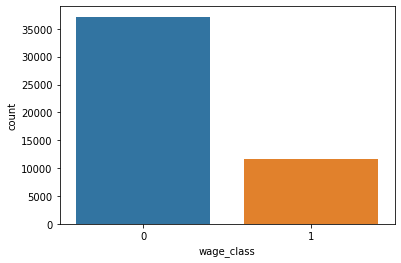

In [188]:
sns.countplot(x='wage_class',data=dataset)

In [0]:
X = dataset.drop('wage_class',axis=1)
Y = dataset['wage_class']

In [0]:
cat_cols = [ col for col in X.columns if X[col].dtypes == 'O']

In [191]:
len(cat_cols)

8

In [0]:
X_enc = pd.get_dummies(X[cat_cols])

In [0]:
X = pd.concat([X,X_enc],axis=1)
X = X.drop(cat_cols,axis=1)

In [194]:
X.shape

(48842, 108)

## Train Test Split

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index,test_index in split.split(X,Y):
  X_train,X_test = X.iloc[train_index],X.iloc[test_index]
  y_train,y_test = Y.iloc[train_index],Y.iloc[test_index]

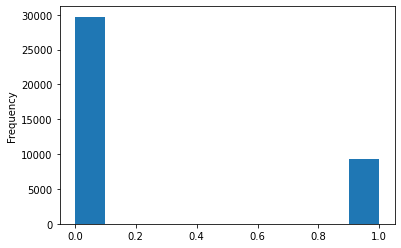

In [200]:
y_train.plot.hist()

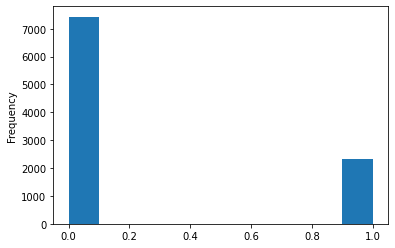

In [201]:
y_test.plot.hist()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
sc = StandardScaler()

## Build Model

In [203]:
import random
xgb = XGBClassifier()
pipe = Pipeline(steps=[('sc', sc),('xgb', XGBClassifier())])
param_grid = dict(xgb__n_estimators = [100,500,1000],xgb__learning_rate = [0.05,0.001,0.01])
print(param_grid)

{'xgb__n_estimators': [100, 500, 1000], 'xgb__learning_rate': [0.05, 0.001, 0.01]}


In [204]:
searchCV = RandomizedSearchCV(pipe,param_grid, cv=5,n_iter=5,scoring='accuracy',verbose=2,n_jobs=-1)  
searchCV.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 12.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('sc',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('xgb',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                                

## Best Parameters

In [205]:
print(f'Best Parameters selected {searchCV.best_params_}')

Best Parameters selected {'xgb__n_estimators': 1000, 'xgb__learning_rate': 0.05}


In [206]:
print('Best number of estimators selected : ',searchCV.best_estimator_.get_params()['xgb__n_estimators'])
print('Best Learning Rate Value  selected : ',searchCV.best_estimator_.get_params()['xgb__learning_rate'])

Best number of estimators selected :  1000
Best Learning Rate Value  selected :  0.05


In [207]:
print(f'Best estimators  selected {searchCV.best_estimator_}')

Best estimators  selected Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)


## Predictions

In [0]:
y_pred = searchCV.predict(X_test)

In [209]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred)}')

Accuracy Score : 0.8730678677449074


## Confusion Matrix

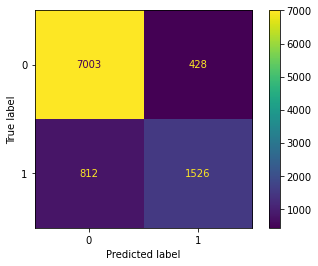

In [211]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(searchCV.best_estimator_,X_test,y_test,values_format='2g')

## ROC Curve

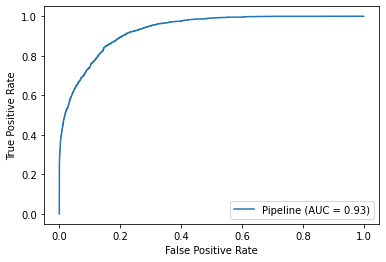

In [217]:
plot_roc_curve(model,X_test,y_test,drop_intermediate=False)